# Lesson 30 demo part 2: optuna hyperparameter optimization

This notebook demonstrates how to use [**Optuna**](https://optuna.org) to automatically find the best hyperparameters for a CNN. Optuna is an awesome optimization framework that can be used to optimize just about *anything* and has a few cool features:

1. Intelligent parameter search with advanced sampling algorithms
2. Built in 'pruning' of non-promising trials (think early stopping...)
3. A built in results logging & dashboard
4. The ability to stop and then resume optimization experiments
5. Built in parallelism over trials

We'll optimize just 2 hyperparameters to keep things simple:
1. **Number of convolutional blocks** (1-4)
2. **Dropout rate** (0.2-0.5)

To run this notebook install `cifar10_tools` via pip: `pip install cifar10_tools`

**Note**: If you are not working in one of the course deeplearning containers, you will also need to pip install `optuna` and `optuna-dashboard` to run this notebook.

```
pip install optuna optuna-dashboard
```

The Optuna dashboard can be viewed either via the VS Code extension 'Optuna Dashboard', or via the built-in web server. Start it with:

```
optuna-dashboard sqlite:///data/simple_optimization.db --host 0.0.0.0
```

In [1]:
# Standard library imports
from pathlib import Path

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Custom package imports
from cifar10_tools.pytorch.training import train_model
from cifar10_tools.pytorch.evaluation import evaluate_model
from cifar10_tools.pytorch.plotting import (
    plot_sample_images,
    plot_learning_curves,
    plot_confusion_matrix
)

# Suppress Optuna info messages (show only warnings and errors)
optuna.logging.set_verbosity(optuna.logging.WARNING)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda:1


In [2]:
# Fixed hyperparameters (not optimized)
batch_size = 1000
initial_filters = 32
fc_units_1 = 512
fc_units_2 = 128
use_batch_norm = True
learning_rate = 0.001

# Optuna settings
n_trials = 20            # Number of Optuna trials
n_epochs_per_trial = 20  # Short training per trial
n_epochs_final = 50      # Longer training for final model

# Storage path for Optuna study
storage_path = Path('../data/simple_optimization.db')
storage_path.parent.mkdir(parents=True, exist_ok=True)
storage_url = f'sqlite:///{storage_path.resolve()}'

# CIFAR-10 class names
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer', 
    'dog', 'frog', 'horse', 'ship', 'truck'
]

num_classes = len(class_names)

## 1. Load and prepare data

In [3]:
# Data directory
data_dir = Path('../data')
data_dir.mkdir(parents=True, exist_ok=True)

# Transform: convert to tensor and normalize RGB channels
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load CIFAR-10
train_dataset = torchvision.datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root=data_dir,
    train=False,
    download=True,
    transform=transform
)

print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')

Training samples: 50000
Test samples: 10000


In [4]:
# Preload data to GPU for faster training
X_train_full = torch.stack([img for img, _ in train_dataset]).to(device)
y_train_full = torch.tensor([label for _, label in train_dataset]).to(device)
X_test = torch.stack([img for img, _ in test_dataset]).to(device)
y_test = torch.tensor([label for _, label in test_dataset]).to(device)

# Split training data into train and validation sets (80/20)
n_train = int(0.8 * len(X_train_full))
indices = torch.randperm(len(X_train_full))

X_train = X_train_full[indices[:n_train]]
y_train = y_train_full[indices[:n_train]]
X_val = X_train_full[indices[n_train:]]
y_val = y_train_full[indices[n_train:]]

print(f'X_train: {X_train.shape}')
print(f'X_val: {X_val.shape}')
print(f'X_test: {X_test.shape}')

X_train: torch.Size([40000, 3, 32, 32])
X_val: torch.Size([10000, 3, 32, 32])
X_test: torch.Size([10000, 3, 32, 32])


In [5]:
# Create DataLoaders
train_tensor_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_tensor_dataset = torch.utils.data.TensorDataset(X_val, y_val)
test_tensor_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_tensor_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_tensor_dataset, batch_size=batch_size, shuffle=False)

print(f'Training batches: {len(train_loader)}')
print(f'Validation batches: {len(val_loader)}')
print(f'Test batches: {len(test_loader)}')

Training batches: 40
Validation batches: 10
Test batches: 10


## 2. Define CNN architecture

This function creates a CNN with a configurable number of convolutional blocks and dropout rate.

In [6]:
def create_cnn(n_conv_blocks: int, dropout_rate: float) -> nn.Sequential:
    '''Create a CNN with configurable architecture.
    
    Args:
        n_conv_blocks: Number of convolutional blocks (1-4)
        dropout_rate: Dropout probability
    
    Returns:
        nn.Sequential model
    '''

    layers = []
    in_channels = 3  # RGB input
    current_size = 32  # Input image size
    
    for block_idx in range(n_conv_blocks):
        out_channels = initial_filters * (2 ** block_idx)
        
        # Conv -> BatchNorm -> ReLU -> Conv -> BatchNorm -> ReLU -> Pool -> Dropout
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())
        
        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())
        
        layers.append(nn.MaxPool2d(2, 2))
        layers.append(nn.Dropout(dropout_rate))
        
        in_channels = out_channels
        current_size //= 2
    
    # Calculate flattened size
    final_channels = initial_filters * (2 ** (n_conv_blocks - 1))
    flattened_size = final_channels * current_size * current_size
    
    # Classifier (3 fully connected layers)
    layers.append(nn.Flatten())
    layers.append(nn.Linear(flattened_size, fc_units_1))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(dropout_rate))
    layers.append(nn.Linear(fc_units_1, fc_units_2))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(dropout_rate))
    layers.append(nn.Linear(fc_units_2, num_classes))
    
    return nn.Sequential(*layers)

## 3. Optuna hyperparameter optimization

We define an objective function that:
1. Samples hyperparameters from defined search spaces
2. Creates and trains a model with those hyperparameters
3. Returns the validation accuracy to maximize

### 3.1. Define training function for trials

In [7]:
def train_trial(
    model: nn.Module,
    optimizer: optim.Optimizer,
    criterion: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    n_epochs: int,
    trial: optuna.Trial
) -> float:
    '''Train a model for a single Optuna trial with pruning support.'''
    
    best_val_accuracy = 0.0
    
    for epoch in range(n_epochs):

        # Training phase
        model.train()

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_accuracy = 100 * val_correct / val_total
        best_val_accuracy = max(best_val_accuracy, val_accuracy)
        
        # Report for pruning
        trial.report(val_accuracy, epoch)
        
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return best_val_accuracy

### 3.2. Define objective function

This is where we specify which hyperparameters to optimize:
- `n_conv_blocks`: 1 to 4 convolutional blocks
- `dropout_rate`: 0.2 to 0.5

In [ ]:
def objective(trial: optuna.Trial) -> float:
    '''Optuna objective function - optimize dropout rate and
    number of covolutional blocks.'''
    
    # Hyperparameters to optimize
    n_conv_blocks = trial.suggest_int('n_conv_blocks', 1, 4)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    
    # Create model
    model = create_cnn(
        n_conv_blocks=n_conv_blocks,
        dropout_rate=dropout_rate
    ).to(device)
    
    # Create optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Set loss function
    criterion = nn.CrossEntropyLoss()
    
    # Train and return validation accuracy
    try:
        return train_trial(
            model=model,
            optimizer=optimizer,
            criterion=criterion,
            train_loader=train_loader,
            val_loader=val_loader,
            n_epochs=n_epochs_per_trial,
            trial=trial
        )

    except torch.cuda.OutOfMemoryError:

        torch.cuda.empty_cache()
        raise optuna.TrialPruned('CUDA OOM')

### 3.3. Run optimization

In [9]:
%%time
    
# Create Optuna study (maximize validation accuracy)
study = optuna.create_study(
    direction='maximize',
    study_name='simple_optimization',
    storage=storage_url,
    load_if_exists=True,
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=3)
)

# Run optimization
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

print(f'Winning validation accuracy: {study.best_trial.value:.2f}%')
print(f'\nBest hyperparameters:')

for key, value in study.best_trial.params.items():
    print(f' {key}: {value}')

print()

  0%|          | 0/20 [00:00<?, ?it/s]

Winning validation accuracy: 84.20%

Best hyperparameters:
 n_conv_blocks: 4
 dropout_rate: 0.2095718780178986
CPU times: user 19min 33s, sys: 7min, total: 26min 34s
Wall time: 26min 18s


### 3.4. Visualize optimization results

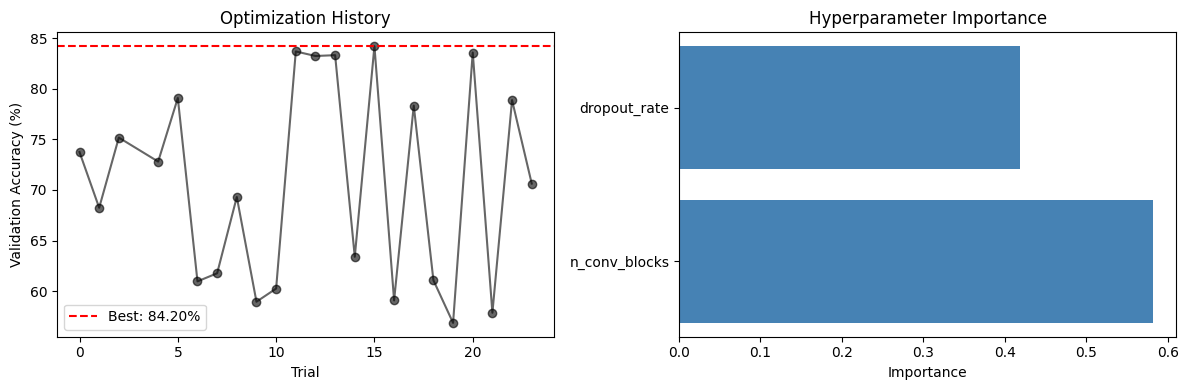

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Optimization history
axes[0].set_title('Optimization History')

trial_numbers = [t.number for t in study.trials if t.value is not None]
trial_values = [t.value for t in study.trials if t.value is not None]

axes[0].plot(trial_numbers, trial_values, 'ko-', alpha=0.6)
axes[0].axhline(y=study.best_value, color='r', linestyle='--', label=f'Best: {study.best_value:.2f}%')
axes[0].set_xlabel('Trial')
axes[0].set_ylabel('Validation Accuracy (%)')
axes[0].legend()

# Hyperparameter importance
axes[1].set_title('Hyperparameter Importance')
completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

if len(completed_trials) >= 5:
    importance = optuna.importance.get_param_importances(study)
    params = list(importance.keys())
    values = list(importance.values())
    axes[1].barh(params, values, color='steelblue')
    axes[1].set_xlabel('Importance')

else:
    axes[1].text(0.5, 0.5, 'Not enough trials\nfor importance analysis', 
                 ha='center', va='center', transform=axes[1].transAxes)

plt.tight_layout()
plt.show()

## 4. Train final model with best hyperparameters

Now we train the winning model configuration for more epochs.

In [11]:
# Get best hyperparameters
best_params = study.best_trial.params

print('Best hyperparameters:')
print(f' - n_conv_blocks: {best_params["n_conv_blocks"]}')
print(f' - dropout_rate: {best_params["dropout_rate"]:.3f}')

# Create model with best hyperparameters
best_model = create_cnn(
    n_conv_blocks=best_params['n_conv_blocks'],
    dropout_rate=best_params['dropout_rate']
).to(device)

# Create optimizer
best_optimizer = optim.Adam(best_model.parameters(), lr=learning_rate)

# Set loss function
criterion = nn.CrossEntropyLoss()

Best hyperparameters:
 - n_conv_blocks: 4
 - dropout_rate: 0.210


In [12]:
%%time

# Train for more epochs
history = train_model(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=best_optimizer,
    epochs=n_epochs_final,
    print_every=10
)

Epoch 1/50 - loss: 1.7795 - accuracy: 31.25% - val_loss: 1.9832 - val_accuracy: 27.61%
Epoch 5/50 - loss: 0.8929 - accuracy: 68.03% - val_loss: 1.1476 - val_accuracy: 61.66%
Epoch 10/50 - loss: 0.5746 - accuracy: 80.08% - val_loss: 0.6262 - val_accuracy: 79.00%
Epoch 15/50 - loss: 0.4158 - accuracy: 85.70% - val_loss: 0.5503 - val_accuracy: 81.97%
Epoch 20/50 - loss: 0.3147 - accuracy: 89.00% - val_loss: 0.4839 - val_accuracy: 84.02%
Epoch 25/50 - loss: 0.2419 - accuracy: 91.45% - val_loss: 0.5741 - val_accuracy: 82.96%
Epoch 30/50 - loss: 0.1839 - accuracy: 93.47% - val_loss: 0.5307 - val_accuracy: 84.98%
Epoch 35/50 - loss: 0.1508 - accuracy: 94.72% - val_loss: 0.5506 - val_accuracy: 85.31%
Epoch 40/50 - loss: 0.1223 - accuracy: 95.66% - val_loss: 0.5861 - val_accuracy: 85.65%
Epoch 45/50 - loss: 0.0956 - accuracy: 96.74% - val_loss: 0.5863 - val_accuracy: 85.54%
Epoch 50/50 - loss: 0.0831 - accuracy: 97.09% - val_loss: 0.6322 - val_accuracy: 85.27%

Training complete.
CPU times: use

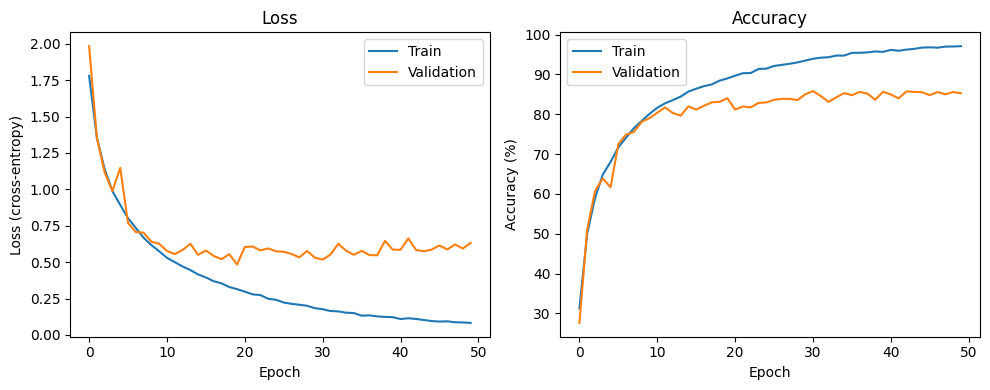

In [13]:
# Plot learning curves
fig, axes = plot_learning_curves(history)
plt.show()

## 5. Evaluate on test set

In [14]:
test_accuracy, predictions, true_labels = evaluate_model(best_model, test_loader)
print(f'Test accuracy: {test_accuracy:.2f}%')

Test accuracy: 84.76%


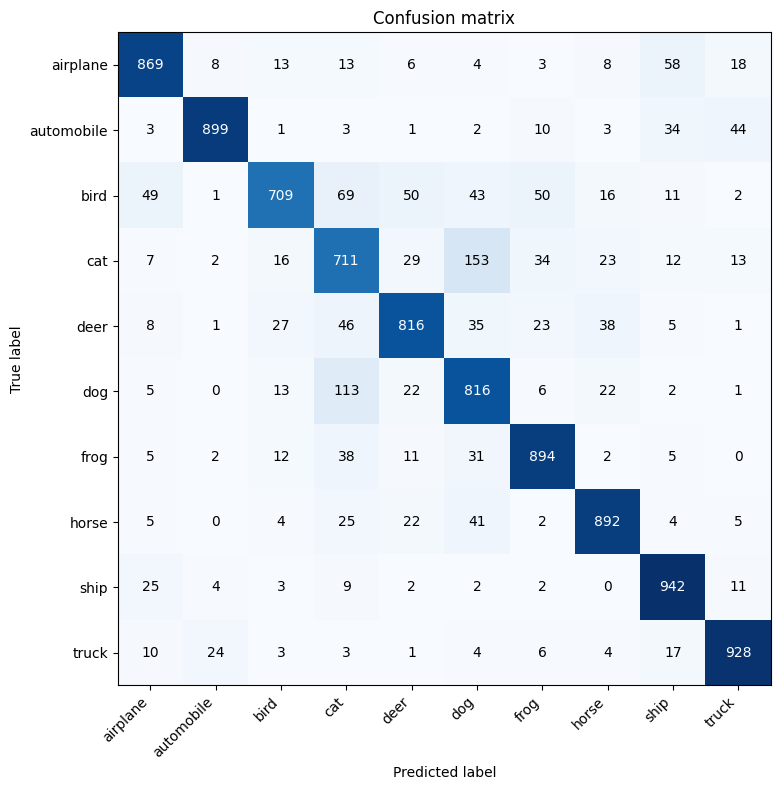

: 

In [ ]:
# Confusion matrix
fig, ax = plot_confusion_matrix(true_labels, predictions, class_names)
plt.show()